## PINNs - Physics-Informed Neural Networks for harmonic oscillators

In this notebook we will implement two harmonic oscillation PINNs, for all cases: (1) underdamped, (2) critically damped and (3) overdamped.

---

The following blog posts/articles were particularly useful:
- Lagaris, I. E., et al., "Artificial neural networks for solving ordinary and partial differential equations", 1998.
- Raissi, M., et al., "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations", 2019.
- Moseley B., "So what is a Physics-Informed Neural Network?", 2021.
- beltoforion.de, "Damped Harmonic Oscillator".

***

In harmonic oscillators, the constants $\delta$ and $\omega_0$ are widely used for simplification and represent a combination of other constants that describe the system, namely: $ \delta = \dfrac{\mu}{2m} $ and $ \omega_0 = \sqrt{\dfrac{k}{m}} $, where $\mu$ is the coefficient of friction, $m$ is the mass of the oscillator and $k$ denotes the spring constant.

As the inertial force is opposed by the friction and the spring's restoring force (Hooke's law), the equation of motion for such a dynamic system can be expressed as `inertial force = - friction - restoring force`, or equivalently:

$$ m\ddot{x} = -\mu\dot{x} - kx $$

$$ or $$

$$ \ddot{x} + \dfrac{\mu}{m}\dot{x} + \dfrac{k}{m}x = 0 \ \ \ \ \ \ (1)$$

The assumption is that the solution of the differential equation that describes such system, is exponential. Therefore, the exponential ansatz of a solution to the differential equation of this system, can be formulated as:

$$ x(t) = Ce^{\lambda t} $$

Calculating the first and second derivatives:

$$ \dot{x}(t) = \lambda C e^{\lambda t} \ \ and \ \  \ddot{x}(t) = \lambda^2 C e^{\lambda t} $$

Plugging these into (1), we can obtain the characteristic equation:

$$ \lambda^2Ce^{\lambda t} + \dfrac{\mu}{m}\lambda Ce^{\lambda t} + \dfrac{k}{m} Ce^{\lambda t} = 0 $$

which can be simplified to:

$$ \lambda^2 + \dfrac{\mu}{m}\lambda + \dfrac{k}{m} = 0 $$

Solving for $ \lambda_{1,2} $ and using the $\delta$ and $\omega_0$ constants:

$$ \lambda_{1,2} = -\delta \pm \sqrt{\delta^2 - \omega_{0}^2} $$

### Underdamped case

The underdamped case describes a harmonic oscillation with $ \delta < \omega_0 $.
The solution for the differential equation (DE) in the underdamped case is:

$ x(t) = e^{-\delta t} (2A\cos(\phi+\omega t)) \ \ $,  with $ \omega = \sqrt{\omega_{0}^2 - \delta^2} $.

Where $A$ describes the amplitude and $\phi$ the phase angle (see [here](https://beltoforion.de/en/harmonic_oscillator/) for a detailed solution of the DE).

For this case, we consider the material/geometry parameters $\delta = 2$ and $\omega_0=20$, and try to learn the solution for the range $x \in [0,1]$.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def UD_oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)  #omega
    phi = np.arctan(-d/w)    #phi - phase angle
    A = 1/(2*np.cos(phi))    #A - amplitude
    cos = torch.cos(phi+w*x) #cos(phi+omega*t)
    sin = torch.sin(phi+w*x) #sin(phi+omega*t)
    exp = torch.exp(-d*x)    #exp(-delta*t)
    y  = exp*2*A*cos         #y - exact solution
    
    return y

def plot_result(epoch,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot for training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(epoch),fontsize="xx-large",color="k")
    plt.axis("off")
    
class FCN(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, n_in, n_out, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden, n_hidden),
                            activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_out)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

Let's start by generating the data:

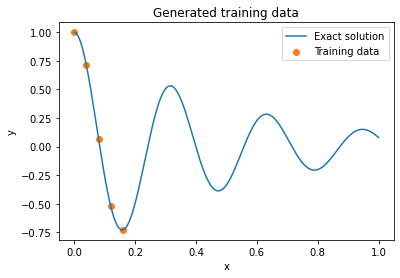

In [3]:
# initialize material/geometry parameters
d, w0 = 2, 20

#analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = UD_oscillator(d, w0, x).view(-1,1)

# slice out a small number of points 
# that will serve as training data
x_data = x[0:100:20]
y_data = y[0:100:20]

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.title("Generated training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### Vanilla FCN
First let's try fitting the data using a vanilla fully-connected network:

In [4]:
torch.manual_seed(123)
model = FCN(1,1,32,3) # (n_in, n_out, n_hidden, n_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
epochs = range(1, 1001)
losses = []
files = []

for epoch in epochs:
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# MSE
    loss.backward()
    optimizer.step()
    losses.append(loss) # keep track of loss in each epoch
        
    # plot results during training
    if (epoch) % 10 == 0: # every 10 epochs
        
        yh = model(x).detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #show plot every 500 epochs:
        #if (epoch) % 500 == 0: plt.show() 
        #else: plt.close("all")
        
        plt.close("all")    
            
save_gif_PIL("ud_nn.gif", files, fps=20, loop=0) # save gif

![SegmentLocal](ud_nn.gif "gif")

Due to the fact that the training sample represents only a limited region of the full domain, the network is unable to capture the behavior of the system outside that limited region.

#### PINN

With a PINN we can incorporate our prior knowledge on the harmonic behavior of this dynamic system. This can be achieved by adding the underlying DE to loss function of the network. This way, the data loss aims to minimize the error in relation to the training sample available, while the 'physics loss' ensures that the learned solution is consistent with the underlying DE, by penalising the residual of the DE over a set of locations sampled from the full domain. In this case, we evaluate the physics loss over a uniform 30-point grid over the full domain ([0,1]).

In [5]:
# sample 30 uniformly spaced points
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
epochs = range(1, 20001)
losses = []
losses_data = []
losses_physics = []
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

In [6]:
for epoch in epochs:
    optimizer.zero_grad()
    
    # Data loss
    yh = model(x_data)
    loss_data = torch.mean((yh-y_data)**2) # MSE
    
    # Physics loss
    yh_physics = model(x_physics)
    
    # calculate first and second derivatives
    # dy/dx
    dx  = torch.autograd.grad(yh_physics, x_physics, torch.ones_like(yh_physics), create_graph=True)[0]
    
    # d^2y/dx^2
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # computes the residual of the harmonic oscillator differential equation
    physics = dx2 + mu*dx + k*yh_physics
    loss_physics = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss_data + loss_physics# add two loss terms together
    losses.append(loss)
    losses_data.append(loss_data)
    losses_physics.append(loss_physics)
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if epoch % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh,xp)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #if epoch % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close("all")
            
save_gif_PIL("ud_pinn.gif", files, fps=20, loop=0)

![SegmentLocal](ud_pinn.gif "gif")

We can see that the PINN aims to ensure that our solution fits well over the full domain, and not only the limited region that the available data might represent.

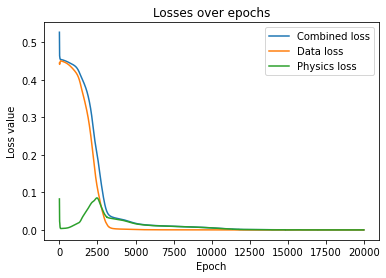

In [7]:
# plot the losses

losses_np = []
losses_data_np = []
losses_physics_np = []

for i in range(len(losses)):
    losses_np.append(losses[i].item())
    losses_data_np.append(losses_data[i].item())
    losses_physics_np.append(losses_physics[i].item())

plt.plot(losses_np, label='Combined loss')
plt.plot(losses_data_np, label='Data loss')
plt.plot(losses_physics_np, label='Physics loss')
plt.title("Losses over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.show()

### Critically damped case

Now let's extend this solution to the critically damped case. Contrary to the underdamped setting, in the critically damped case we have $ \delta = \omega_0 $. The analytical solution for the critically damped case DE is:

$$ x(t) = e^{-\delta t} (C_1e +t \ C_2) $$

where $C_{1,2}$ are integration constants that can be determined from the given initial conditions (see [here](https://beltoforion.de/en/harmonic_oscillator/) for a detailed solution of the DE).

For this case, we consider the material/geometry parameters $\delta = 20$ and $\omega_0=20$, and try to learn the solution for the range $x \in [0,1]$. In addition, we assume the initial conditions $x_0 = 0$ and $v_0 = 2$ in order to calculate c1 and c2.

In the critically damped and overdamped cases, c1 and c2 are calculated by solving the equation system of $x(t)$ and $v(t) = \dot{x}(t)$ for the initial conditions for starting position $x_0$ and starting velocity $v_0$.

In [8]:
def CD_oscillator(d, w0, x, x0, v0):
    """Defines the analytical solution to the 1D critically damped harmonic oscillator problem. 
    Equations from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d == w0
    
    c1 = x0               # c1,2 are computed using the predefined
    c2 = v0 + (d*x0)      # initial conditions x0 and v0
    summ = (c1 + x*c2)    # c1 + t*c2
    exp = torch.exp(-d*x) # exp(-d*t)
    y = exp*summ          # y - exact solution
    
    return y

# plot_result redefined with different x,y limits and text position
def plot_result(epoch,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot for training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 0.05)
    plt.text(1.065, 0.1,"Training step: %i"%(epoch),fontsize="xx-large",color="k")
    plt.axis("off")

Let's start by generating the data:

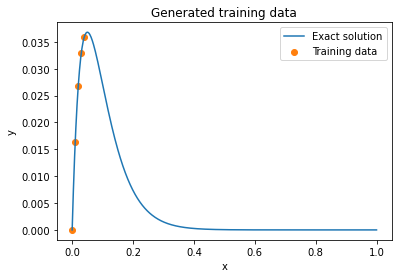

In [9]:
# initial conditions
x0, v0 = 0, 2 #starting position/velocity

# initialize material/geometry parameters
d = w0 = 20

#analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = CD_oscillator(d, w0, x, x0, v0).view(-1,1)

# slice out a small number of points 
#that will serve as training data
x_data = x[0:25:5]
y_data = y[0:25:5]

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.title("Generated training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### FCN
Fitting the FCN for the critically damped case:

In [10]:
torch.manual_seed(123)
model = FCN(1,1,18,3) # (n_in, n_out, n_hidden, n_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)
epochs = range(1, 801)
losses = []
files = []

for epoch in epochs:
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# MSE
    loss.backward()
    optimizer.step()
    losses.append(loss)
        
    # plot results during training
    if (epoch) % 10 == 0: # every 10 epochs
        
        yh = model(x).detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #show plot every 500 epochs:
        #if (epoch) % 500 == 0: plt.show() 
        #else: plt.close("all")
        plt.close("all")    
            
save_gif_PIL("cd_nn.gif", files, fps=20, loop=0)

![SegmentLocal](cd_nn.gif "gif")

#### PINN
Fitting a PINN for the critically damped case:

In [11]:
# sample 30 uniformly spaced points
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,15,3)
epochs = range(1, 20001)
losses = []
losses_data = []
losses_physics = []
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
files = []

In [12]:
for epoch in epochs:
    optimizer.zero_grad()
    
    # Data loss
    yh = model(x_data)
    loss_data = torch.mean((yh-y_data)**2) # MSE
    
    # Physics loss
    yh_physics = model(x_physics)
    
    # calculate first and second derivatives
    # dy/dx
    dx  = torch.autograd.grad(yh_physics, x_physics, torch.ones_like(yh_physics), create_graph=True)[0]
    
    # d^2y/dx^2
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
    
    # computes the residual of the harmonic oscillator differential equation
    physics = dx2 + mu*dx + k*yh_physics # from (1) (beltoforion.de)
    loss_physics = (1e-5)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss_data + loss_physics # add two loss terms together
    loss.backward()
    optimizer.step()
    losses.append(loss)
    losses_data.append(loss_data)
    losses_physics.append(loss_physics)
    
    
    # plot the result as training progresses
    if epoch % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh,xp)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #if epoch % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close("all")
            
save_gif_PIL("cd_pinn.gif", files, fps=20, loop=0)

![SegmentLocal](cd_pinn.gif "gif")

### Overdamped case

Finally, in the overdamped case we have $ \delta > \omega_0 $. The analytical solution for the overdamped case DE is:

$ x(t) = e^{-\delta t} (C_1 \ e^{\alpha t} \ + \ C_2 \ e^{-\alpha t}) $, with $ \alpha = \sqrt{\delta^2 - \omega_{0}^2} $

where $C_{1,2}$ are integration constants that can be determined from the given initial conditions (see [here](https://beltoforion.de/en/harmonic_oscillator/) for a detailed solution of the DE).

For this case, we consider the material/geometry parameters $\delta = 20$ and $\omega_0=1$, and try to learn the solution for the range $x \in [0,1]$. In addition, we assume the initial conditions $x_0 = 0$ and $v_0 = 2$ in order to calculate c1 and c2.

In [13]:
def OD_oscillator(d, w0, x, x0, v0):
    """Defines the analytical solution to the 1D overdamped harmonic oscillator problem. 
    Equations from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d > w0
    
    a = np.sqrt(d**2-w0**2)    # a
    c1 = (x0*(a+d)+v0)/(2*a)   # c1,2 computed using the predefined
    c2 = -c1                   # initial conditions x0 and v0
    exp1 = torch.exp(a*x)      # exp(a*t)
    exp2 = torch.exp(-a*x)     # exp(-a*t)
    summ = (c1*exp1)+(c2*exp2) # c1*exp(a*t)+c2*exp(-a*t)
    exp3 = torch.exp(-d*x)     # exp(-d*t) 
    y = exp3*summ              # y - exact solution
    
    return y

# plot_result redefined with different x,y limits and text position
def plot_result(epoch,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot for training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 0.05)
    plt.text(1.065, 0.1,"Training step: %i"%(epoch),fontsize="xx-large",color="k")
    plt.axis("off")

Let's start by generating the data - Note that the critically damped and overdamped cases can be easily fitted with non-physics-informed NNs, therefore for this example we select a particularly limited range to be represented with the training data, so that we see the effect of the physics loss in action.

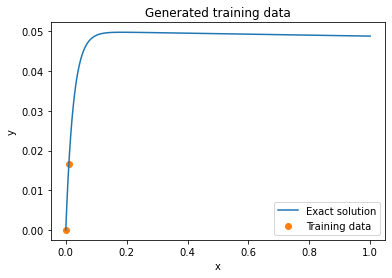

In [14]:
# initial conditions
x0, v0 = 0, 2 #starting position/velocity

# initialize material/geometry parameters
d, w0 = 20, 1

#analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = OD_oscillator(d, w0, x, x0, v0).view(-1,1)

# slice out a small number of points 
#that will serve as training data
x_data = x[0:10:5]
y_data = y[0:10:5]

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.title("Generated training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### FCN
Fitting the FCN in the overdamped case:

In [15]:
torch.manual_seed(123)
model = FCN(1,1,15,3) # (n_in, n_out, n_hidden, n_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
epochs = range(1, 501)
losses = []
files = []

for epoch in epochs:
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# MSE
    loss.backward()
    optimizer.step()
    losses.append(loss)
        
    # plot results during training
    if (epoch) % 10 == 0: # every 10 epochs
        
        yh = model(x).detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #show plot every 500 epochs:
        #if (epoch) % 500 == 0: plt.show() 
        #else: plt.close("all")
        plt.close("all")    
            
save_gif_PIL("od_nn.gif", files, fps=20, loop=0)

![SegmentLocal](od_nn.gif "gif")

#### PINN
Fitting the overdamped case data with a PINN:

In [16]:
# sample 30 uniformly spaced points
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,9,3)
epochs = range(1, 20001)
losses = []
losses_data = []
losses_physics = []
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []

In [17]:
for epoch in epochs:
    optimizer.zero_grad()
    
    # Data loss
    yh = model(x_data)
    loss_data = torch.mean((yh-y_data)**2) # MSE
    
    # Physics loss
    yh_physics = model(x_physics)
    
    # calculate first and second derivatives
    # dy/dx
    dx  = torch.autograd.grad(yh_physics, x_physics, torch.ones_like(yh_physics), create_graph=True)[0]
    
    # d^2y/dx^2
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
    
    # computes the residual of the harmonic oscillator differential equation
    physics = dx2 + mu*dx + k*yh_physics # from (1) (beltoforion.de)
    loss_physics = (1e-5)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss_data + loss_physics # add two loss terms together
    loss.backward()
    optimizer.step()
    losses.append(loss)
    losses_data.append(loss_data)
    losses_physics.append(loss_physics)
    
    
    # plot the result as training progresses
    if epoch % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(epoch,x,y,x_data,y_data,yh,xp)
        
        file = "./PINNplots/"+str(epoch)+".png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        #if epoch % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close("all")
            
save_gif_PIL("od_pinn.gif", files, fps=20, loop=0)

![SegmentLocal](od_pinn.gif "gif")